# Dynamic mode decomposition on two mixed spatial signals

We apply dynamic mode decomposition (DMD) to a spatiotemporal, linear system,
which is created as a superposition from two mixed spatiotemporal signals
(this is example 1.4 in Kutz et al., "*Dynamic Mode Decomposition*", SIAM 2016):

$$f(x,t) = f_1(x,t) + f_2(x,t)$$

with

$$
\begin{aligned}
    f_1(x,t) &= \mathrm{sech}(x+3) e^{j2.3t},\\
    f_2(x,t) &= 2\,\mathrm{sech}(x)\,\mathrm{tanh}(x) e^{j2.8t}.
\end{aligned}
$$

These two individual signals have frequencies $\omega_1 = 2.3$ and $\omega_2=2.8$
with each a distinct spatial structure.

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
import sys
sys.path.append('../src')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import pykoopman as pk

Time and space discretizations

In [3]:
tArray = np.linspace(0, 4*np.pi, 200)  # Time array for solution
dt = tArray[1] - tArray[0] # Time step
xArray = np.linspace(-10,10,400)
[Xgrid, Tgrid] = np.meshgrid(xArray, tArray)

Define helper function, hyperbolic secant

In [4]:
def sech(x):
    return 1./np.cosh(x)

Generate training data from two spatiotemporal signals

In [5]:
omega1 = 2.3
omega2 = 2.8
f1 = np.multiply(sech(Xgrid+3), np.exp(1j*omega1*Tgrid))
f2 = np.multiply( np.multiply(sech(Xgrid), np.tanh(Xgrid)), 2*np.exp(1j*omega2*Tgrid))
f = f1 + f2

In [6]:
def plot_dynamics(Xgrid, Tgrid, f, fig=None, title='', subplot=111):
    if fig is None:
        fig = plt.figure(figsize=(12, 4))

    time_ticks = np.array([0, 1*np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
    time_labels = ('0', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$')

    ax = fig.add_subplot(subplot, projection='3d')
    surf = ax.plot_surface(Xgrid, Tgrid, f, rstride=1)
    cset = ax.contourf(Xgrid, Tgrid, f, zdir='z', offset=-1.5, cmap=cm.ocean)
    ax.set(
        xlabel=r'$x$',
        ylabel=r'$t$',
        title=title,
        yticks=time_ticks,
        yticklabels=time_labels,
        xlim=(-10, 10),
        zlim=(-1.5, 1),
    )
    ax.autoscale(enable=True, axis='y', tight=True)

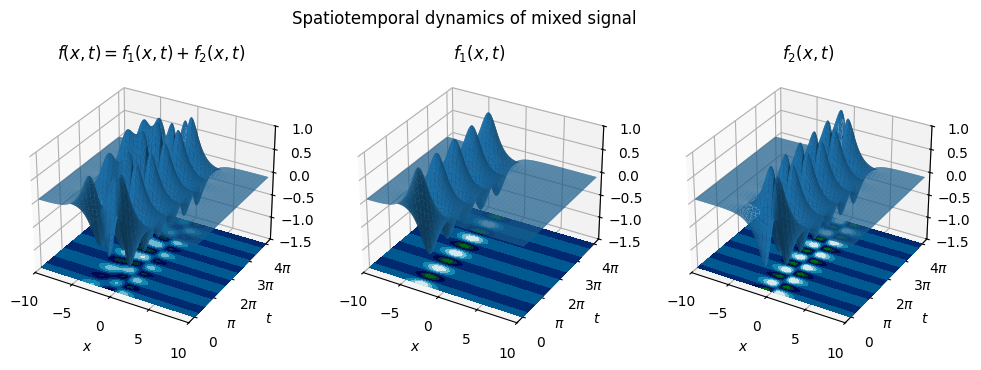

In [7]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Spatiotemporal dynamics of mixed signal')

plot_dynamics(Xgrid, Tgrid, f, fig=fig, title=r'$f(x, t) = f_1(x,t) + f_2(x,t)$', subplot=131)
plot_dynamics(Xgrid, Tgrid, f1, fig=fig, title=r'$f_1(x,t)$', subplot=132)
plot_dynamics(Xgrid, Tgrid, f2, fig=fig, title=r'$f_2(x,t)$', subplot=133)

Instantiate and fit a Koopman model using DMD on training data

In [8]:
from pydmd import DMD

dmd=DMD(svd_rank=2)

model = pk.Koopman(regressor=dmd)
model.fit(f, dt=dt)

Koopman(observables=Identity(),
        regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x734c755fa260>))

Text(0, 0.5, '$Im(\\lambda)$')

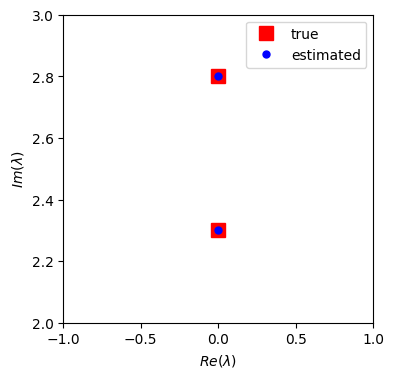

In [9]:
K = model.A

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/dt

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot([0,0], [omega1,omega2],'rs', label='true',markersize=10)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated',markersize=5)


ax.set_xlim([-1,1])
ax.set_ylim([2,3])
plt.legend()
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')
# print(omega1,omega2)

Check if model can reconstruct the training data by predicting starting from the first snapshot.

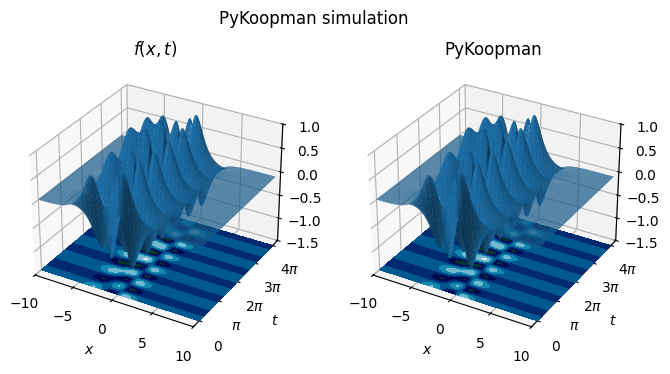

In [10]:
f_predicted = np.vstack((f[0], model.simulate(f[0], n_steps=f.shape[0] - 1)))

fig = plt.figure(figsize=(8, 4))
fig.suptitle('PyKoopman simulation')

plot_dynamics(Xgrid, Tgrid, f, fig=fig, title=r'$f(x, t)$', subplot=121)
plot_dynamics(Xgrid, Tgrid, f_predicted, fig=fig, title='PyKoopman', subplot=122)